In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import seaborn as sns
import swifter
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import preprocessing
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
cd /Users/rabarry/Documents/Insight/NYC data/SafeEats/data/processed

/Users/rabarry/Documents/Insight/NYC data/SafeEats/data/processed


# Prepare data for models

### Load in the data

In [265]:
data = pd.read_csv('HD_NY311_Hoods.csv')

### Code data labels
#### Good = 0 or 1 critical flags at last inspection
#### Bad = 2 or more critical flags at last inspection

In [266]:
data['is_good_lastInsp'] = np.where(data['Last_Insp_Num_CriticialFlags']>1,0,1)
print(data['is_good_lastInsp'].value_counts())

1    18431
0     7216
Name: is_good_lastInsp, dtype: int64


In [267]:
clean = (data['is_good_lastInsp']==1)
dirty = (data['is_good_lastInsp']==0)
print(f"\033[1m\033[94mProportion of dirty to clean samples = \033[30m{(dirty.sum() / clean.sum()) * 100:.2f}% \n")

Proportion of dirty to clean samples = 39.15% 



### Re-code Cuisine Type
#### Went from 84 types to 6

In [268]:
conditions = [
    (data['CUISINE DESCRIPTION'] == 'American') |  (data['CUISINE DESCRIPTION'] == 'Hamburgers') | (data['CUISINE DESCRIPTION'] == 'Steak') | (data['CUISINE DESCRIPTION'] == 'Soul Food') | (data['CUISINE DESCRIPTION'] == 'Barbecue') | (data['CUISINE DESCRIPTION'] == 'Hotdogs/Pretzels') | (data['CUISINE DESCRIPTION'] == 'Hotdogs') | (data['CUISINE DESCRIPTION'] == 'Californian') | (data['CUISINE DESCRIPTION'] == 'Southwestern') | (data['CUISINE DESCRIPTION'] == 'Chicken'),
    (data['CUISINE DESCRIPTION'] == 'Chinese') | (data['CUISINE DESCRIPTION'] == 'Japanese') | (data['CUISINE DESCRIPTION'] == 'Asian') | (data['CUISINE DESCRIPTION'] == 'Thai') | (data['CUISINE DESCRIPTION'] == 'Korean') | (data['CUISINE DESCRIPTION'] == 'Vietnamese/Cambodian/Malaysia') | (data['CUISINE DESCRIPTION'] == 'Chinese/Japanese') | (data['CUISINE DESCRIPTION'] == 'Filipino') | (data['CUISINE DESCRIPTION'] == 'Indonesian'), 
    (data['CUISINE DESCRIPTION'] == 'Café/Coffee/Tea') | (data['CUISINE DESCRIPTION'] == 'Bakery') | (data['CUISINE DESCRIPTION'] == 'Donuts') | (data['CUISINE DESCRIPTION'] == 'Juice, Smoothies, Fruit Salads') | (data['CUISINE DESCRIPTION'] == 'Ice Cream, Gelato, Yogurt, Ices') | (data['CUISINE DESCRIPTION'] == 'Bottled beverages, including water, sodas, juices, etc. ') | (data['CUISINE DESCRIPTION'] == 'Pancakes/Waffles')| (data['CUISINE DESCRIPTION'] == 'Nuts/Confectionary'),
    (data['CUISINE DESCRIPTION'] == 'Pizza') | (data['CUISINE DESCRIPTION'] == 'Italian') | (data['CUISINE DESCRIPTION'] == 'Pizza/Italian'),
    (data['CUISINE DESCRIPTION'] == 'Mexican') | (data['CUISINE DESCRIPTION'] == 'Latin (Cuban, Dominican, Puerto Rican, South & Central American)') | (data['CUISINE DESCRIPTION'] == 'Spanish') | (data['CUISINE DESCRIPTION'] == 'Tex-Mex') | (data['CUISINE DESCRIPTION'] == 'Peruvian') | (data['CUISINE DESCRIPTION'] == 'Tapas') | (data['CUISINE DESCRIPTION'] == 'Chilean')      
]
choices = ['American', 'Asian', 'Cafe/Dessert', 'Italian', 'Latin']
data['Cuisine_Reduced'] = np.select(conditions, choices, default='Other')
print(data['Cuisine_Reduced'].value_counts())
data['Cuisine_Reduced'].isnull().sum(axis = 0);

American        6948
Other           5020
Asian           4466
Cafe/Dessert    3881
Latin           2700
Italian         2632
Name: Cuisine_Reduced, dtype: int64


### Recode all other categorical variables

In [269]:
data['Second_Last_Insp_Type_CAT']=data['Second_Last_Insp_Type'].astype('category')
data['Second_Last_Insp_Type_CAT'] = data['Second_Last_Insp_Type_CAT'].cat.codes
data['Second_Last_Insp_Num_CriticialFlags_CAT']=data['Second_Last_Insp_Num_CriticialFlags'].astype('category')
data['BORO_CAT']=data['BORO'].astype('category')
data['BORO_CAT'] = data['BORO_CAT'].cat.codes
data['num_years_active_CAT']=data['num_years_active'].astype('category')
data['Cuisine_CAT']=data['Cuisine_Reduced'].astype('category')
data['Cuisine_CAT'] = data['Cuisine_CAT'].cat.codes
data['is_good_lastInsp']= data['is_good_lastInsp'].astype('category')
data['ny311_number_of_complaints_3mo']= data['ny311_number_of_complaints_3mo'].astype('category')

### Remove restaurants that don't have a previous inspection

In [270]:
len(data);
data = data[data['Second_Last_Insp_Type'].notnull()]
len(data);

### Format data types 

In [271]:
data['Median household income (2018$)'] = data['Median household income (2018$)'].str[1:]
data['Poverty rate'] = data['Poverty rate'].str[:-1]
data['Public housing (% of rental units)'] = data['Public housing (% of rental units)'].str[:-1]

data = data.swifter.apply(lambda x: x.str.strip() if x.dtype =='object' else x)

data = data.swifter.apply(lambda x: x.str.replace(',','') if x.dtype =='object' else x)

data['Median household income (2018$)'] = data['Median household income (2018$)'].astype('float64')

data['Population'] = data['Population'].astype('float64')
data['Poverty rate'] = data['Poverty rate'].astype('float64')
data['Public housing (% of rental units)'] = data['Public housing (% of rental units)'].astype('float64')

### Plot restaurants on a map

In [202]:
import descartes
import geopandas as gpd
import gmplot

In [111]:
gmap = gmplot.GoogleMapPlotter(40, 74, 5)
gmap.scatter(data['Latitude'][:1000], data['Longitude'][:1000], 'red', size = 10)
gmap.draw('gmplot.html')

In [193]:
plt.rcParams['figure.figsize'] = (20, 10)   # Resize map figure, default is really small 
nyc = gpd.read_file('new-york-city-boroughs.geojson')   # Load JSON file
HD_gd = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))

In [232]:
nyc.head()
HD_gd.columns

,name,cartodb_id,created_at,updated_at,geometry
0,Staten Island,1,2013-03-09T02:42:03,2013-03-09T02:42:03,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,Queens,2,2013-03-09T02:42:03,2013-03-09T02:42:03,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,Brooklyn,3,2013-03-09T02:42:03,2013-03-09T02:42:03,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,Manhattan,4,2013-03-09T02:42:03,2013-03-09T02:42:03,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,Bronx,5,2013-03-09T02:42:03,2013-03-09T02:42:03,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


Index(['Unnamed: 0', 'CAMIS', 'Second_Last_Insp_Type', 'Second_Last_Insp_Date',
       'Second_Last_Insp_Num_CriticialFlags', 'Last_Insp_Type',
       'Last_Insp_Date', 'Last_Insp_Num_CriticialFlags', 'Insp_Date_Diff',
       'DBA', 'BORO', 'ZIPCODE', 'CUISINE DESCRIPTION', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'BBL', 'NTA', 'total_critical_flags', 'first_inspection_date',
       'last_inspection_date', 'num_years_active',
       'avg_num_critical_flags_per_year', 'location', 'is_good_overall',
       'is_good_lastInsp', 'ny311_number_of_complaints_6mo',
       'ny311_number_of_complaints_12mo', 'ny311_number_of_complaints_3mo',
       'Cuisine_Reduced', 'Unnamed: 0.1', 'District Name', 'zip',
       'Income diversity ratio', 'Median household income (2018$)',
       'Population', 'Population density (1,000 persons per square mile)',
       'Poverty rate', 'Public housing (% of rental units)',
       'Racial diversity index

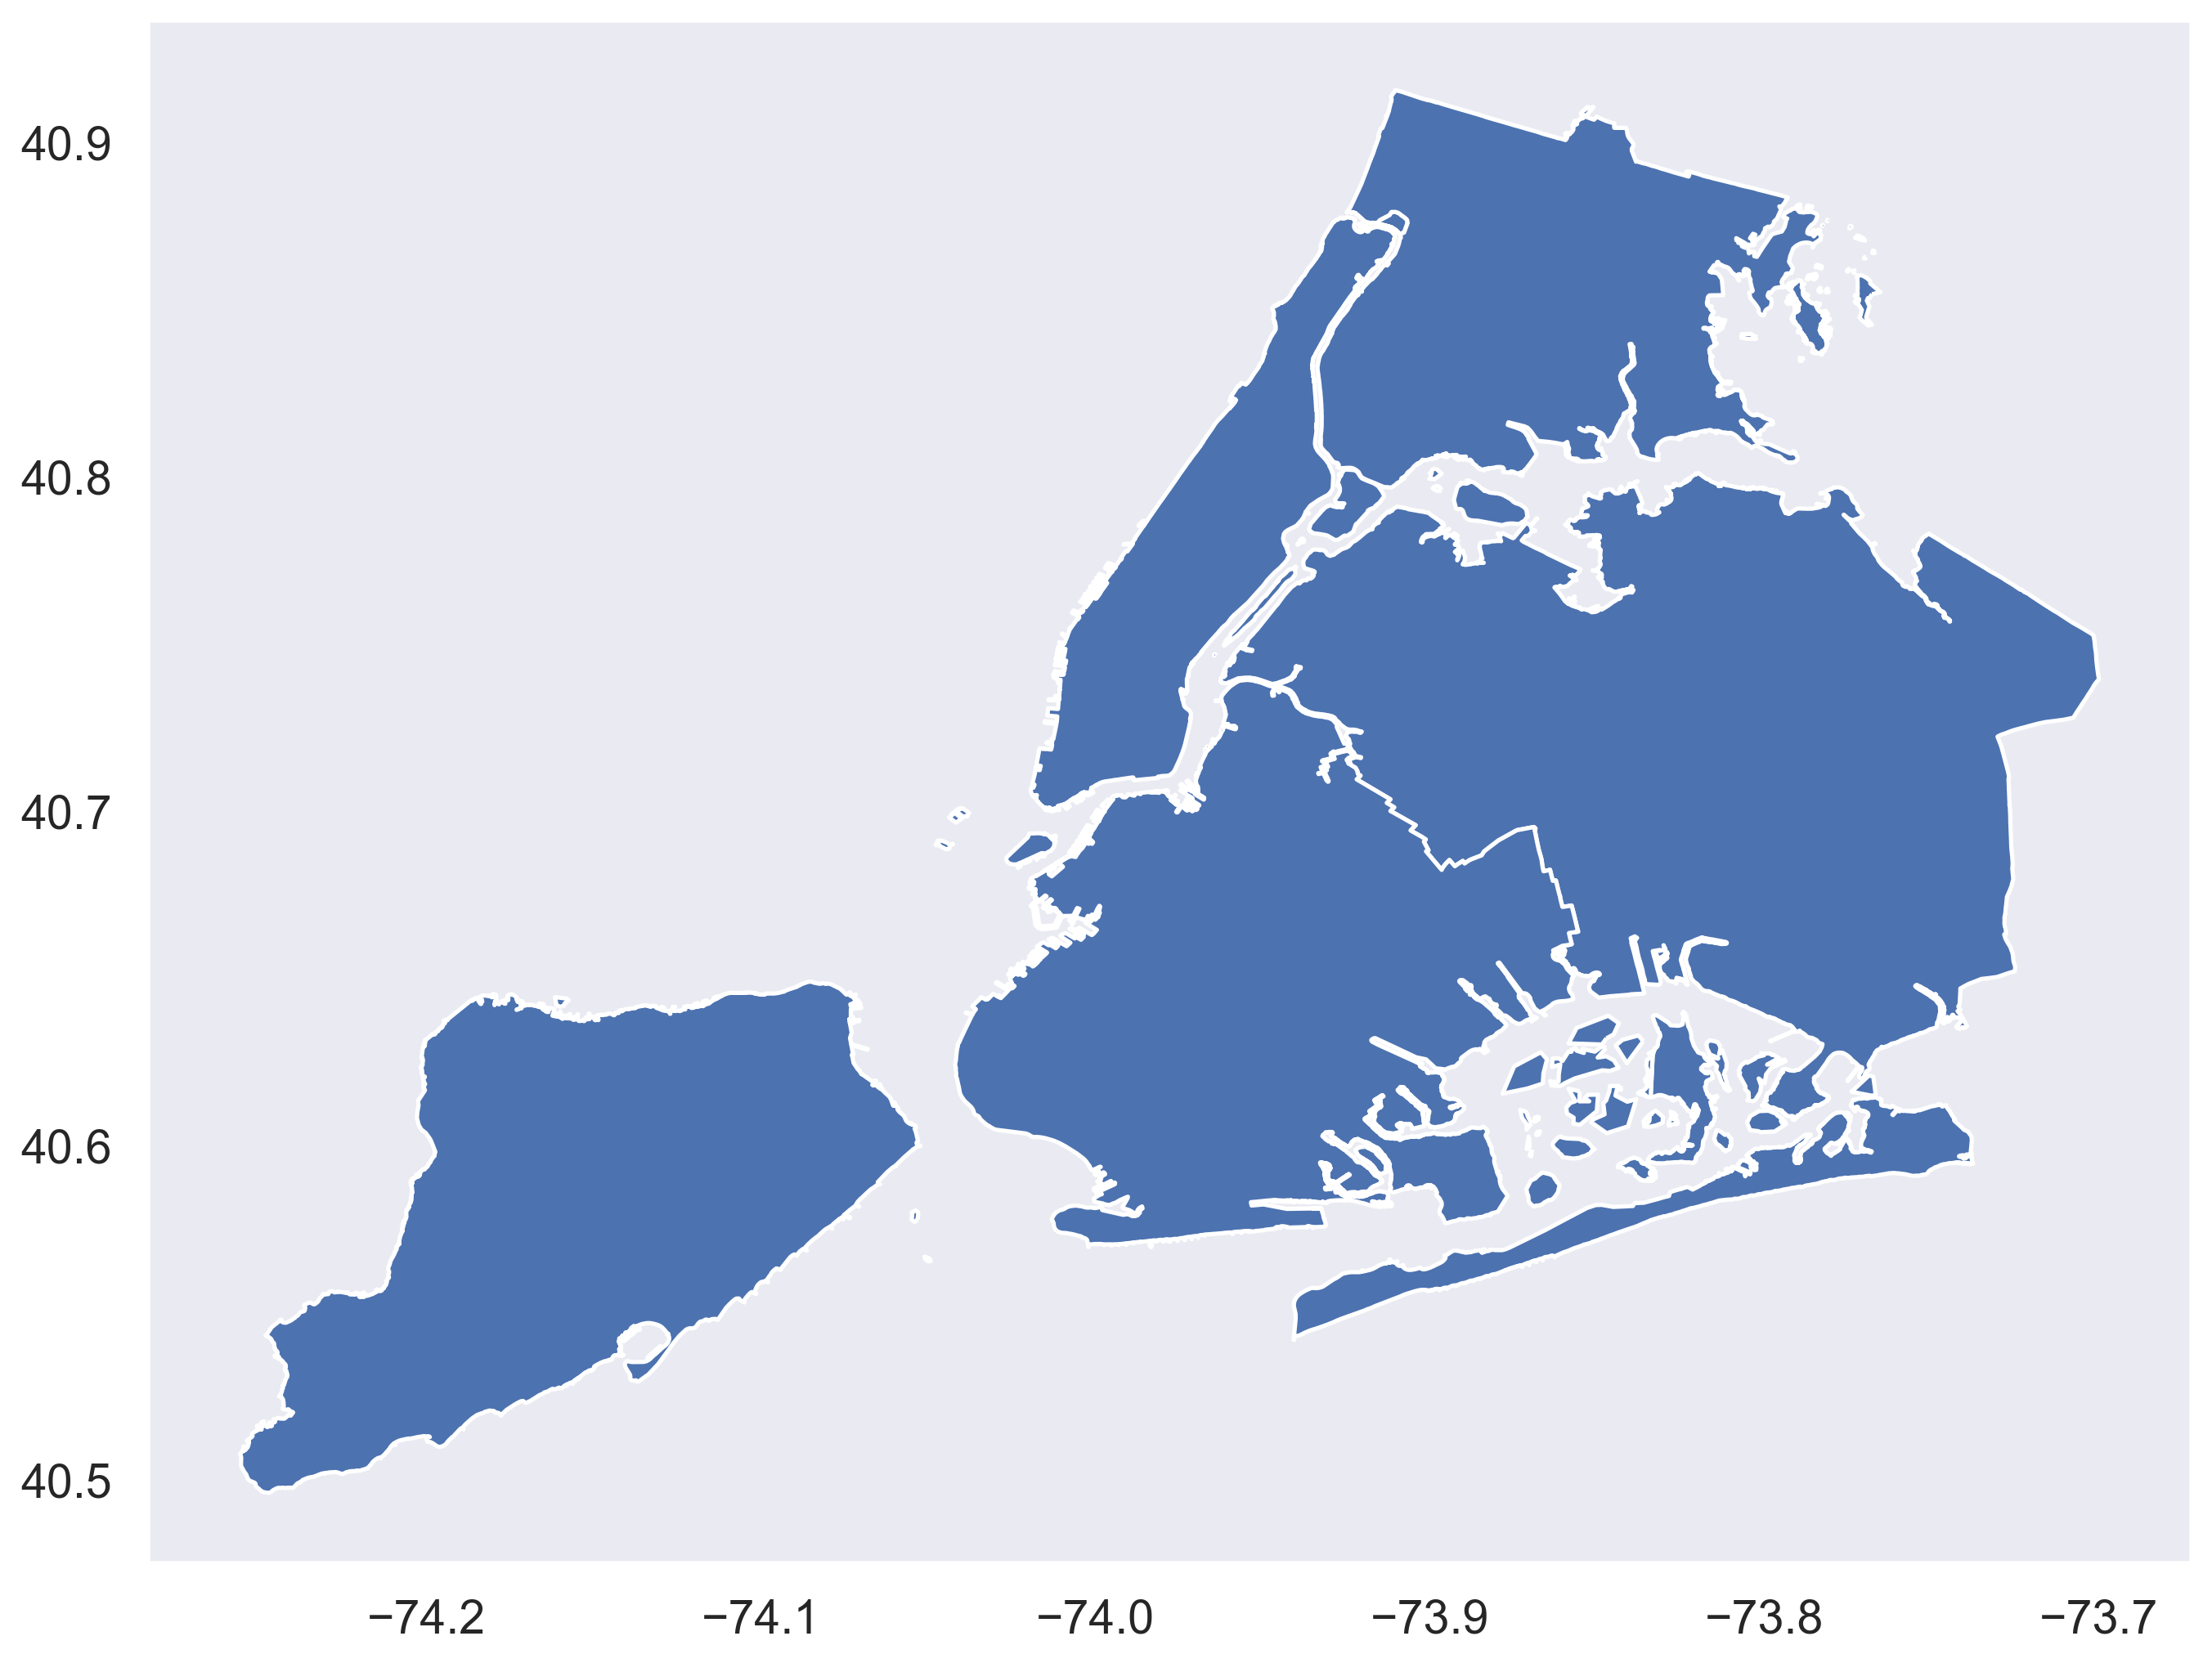

In [203]:
nyc.plot()

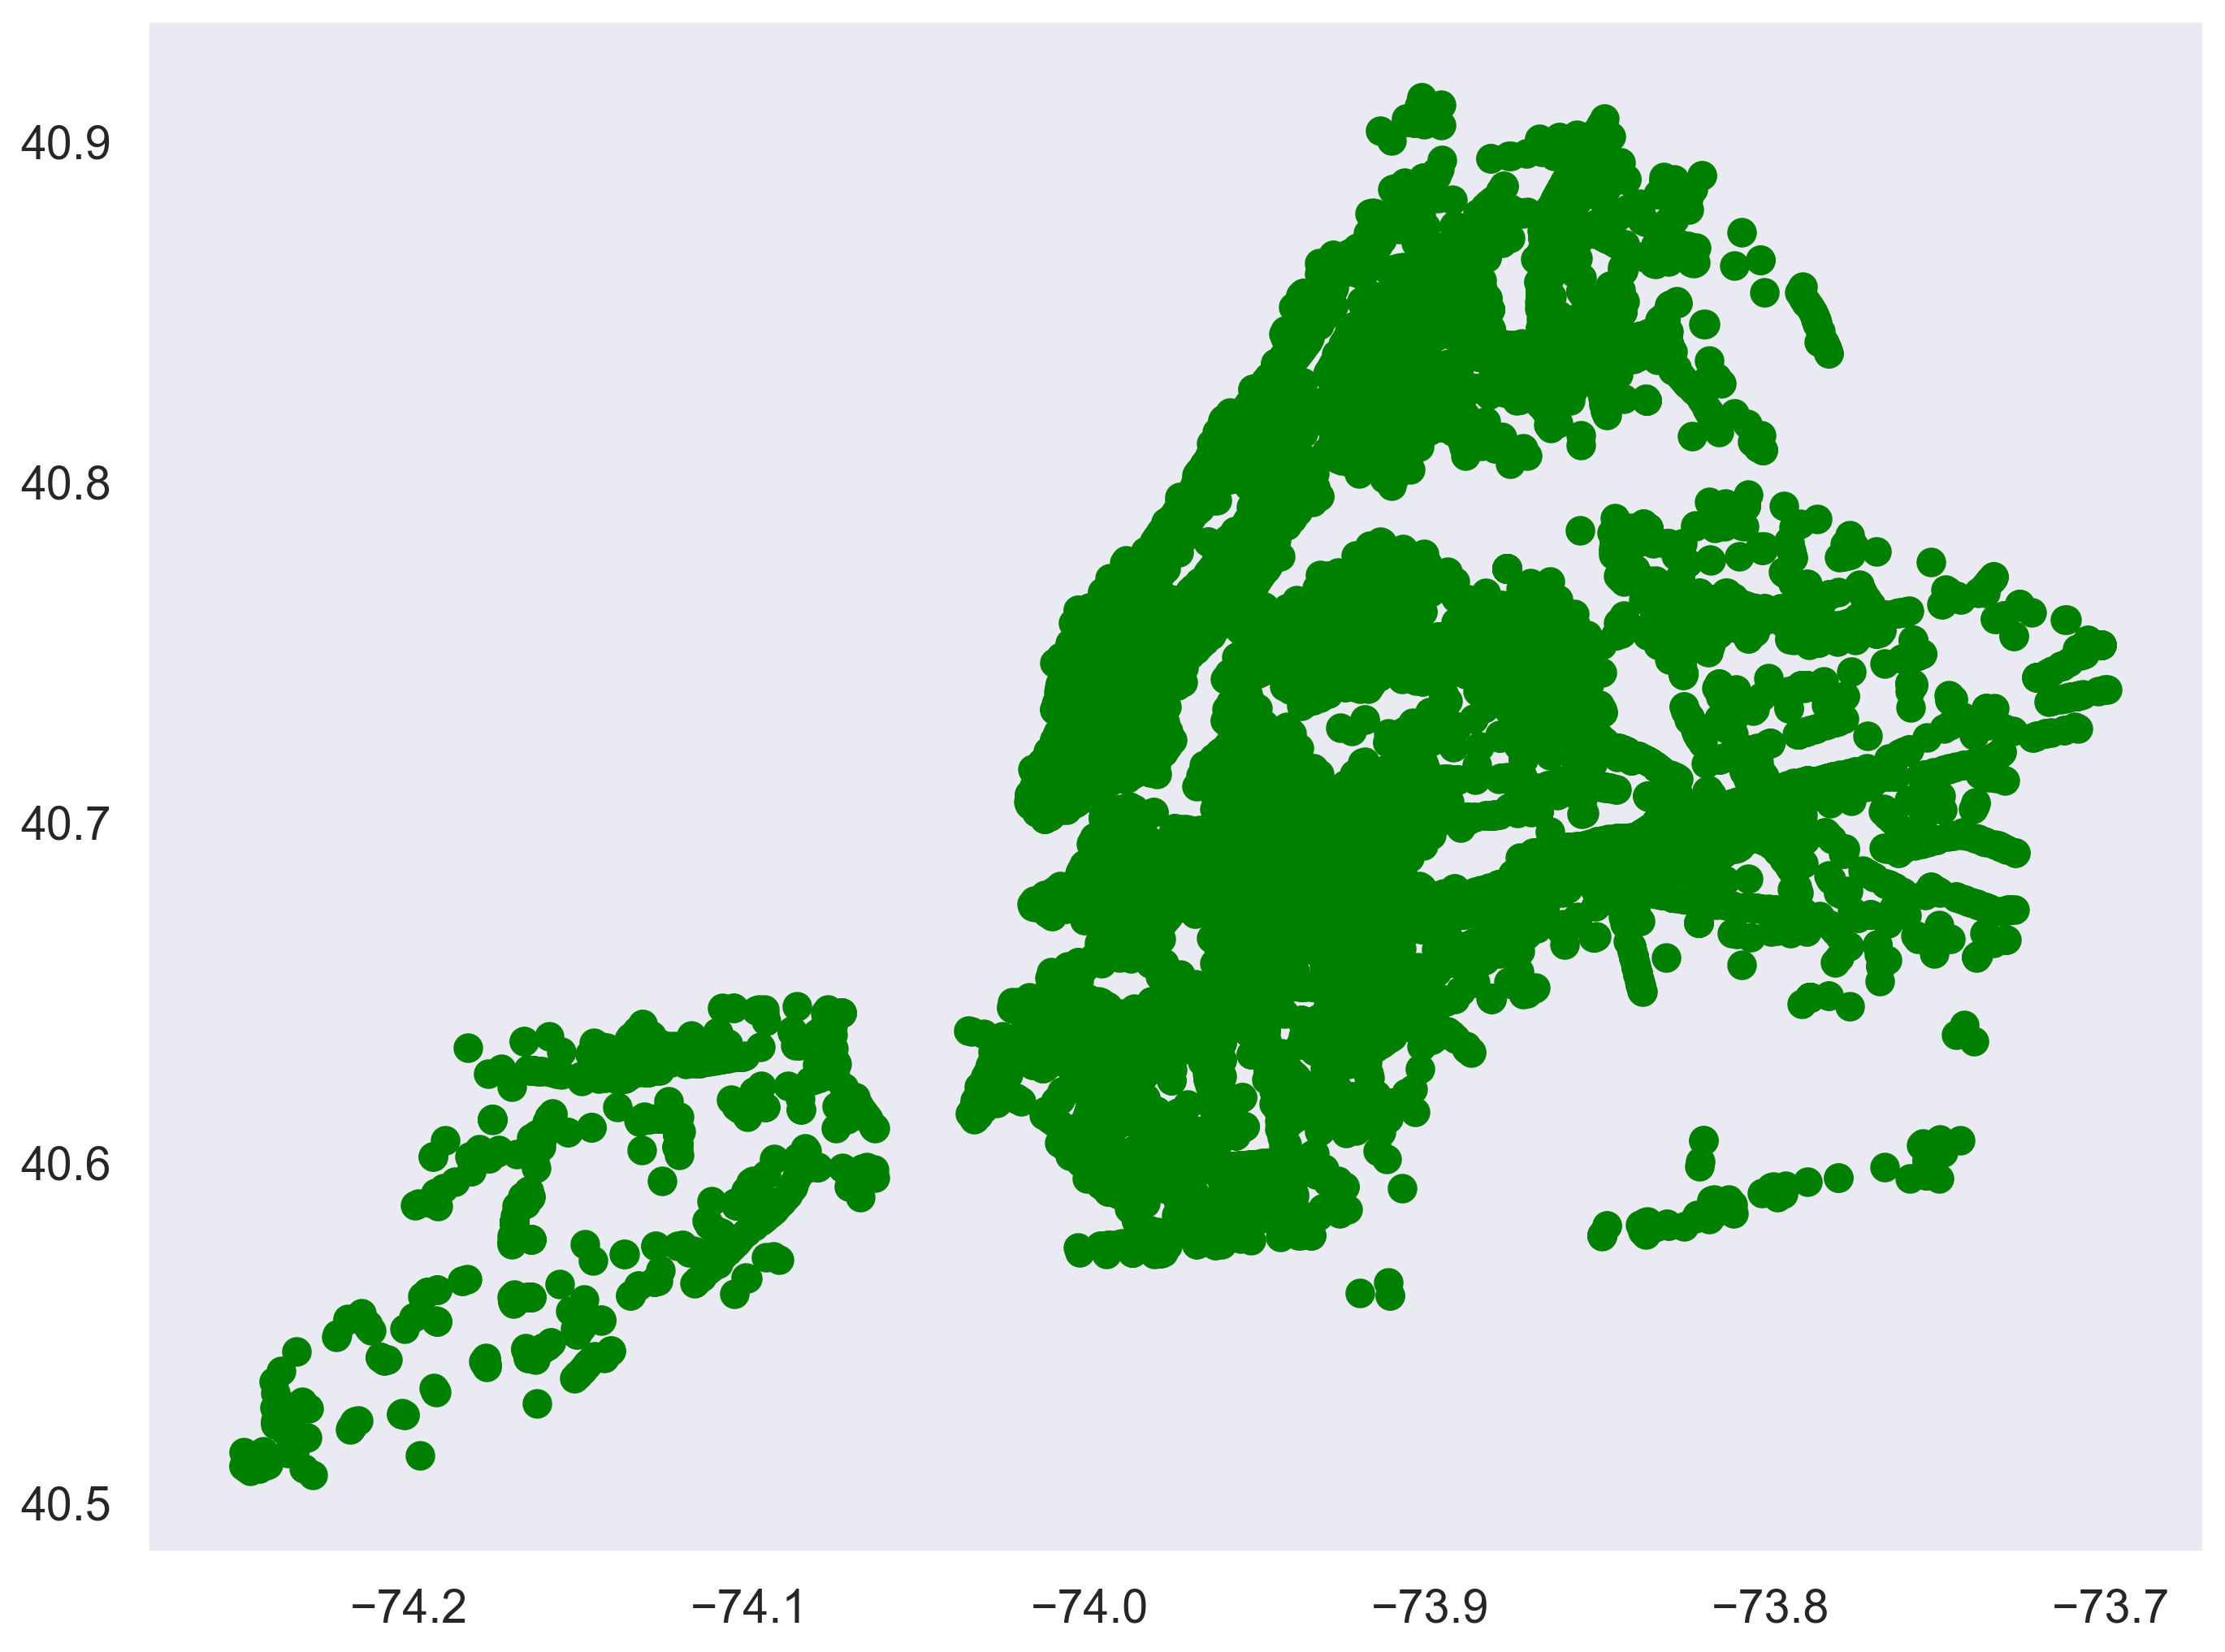

In [205]:
import matplotlib
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)
from matplotlib import rcParams
rcParams['figure.dpi']=250
#P.set_axis_bgcolor('black')
#P = HD_gd.plot(kind = 'scatter', x = 'Longitude', y = 'Latitude', color = 'green')
HD_gd.plot(color = 'green')

In [208]:
geo_merged = HD_gd.merge(nyc, left_on= "BORO", right_on = "name", how= 'left')

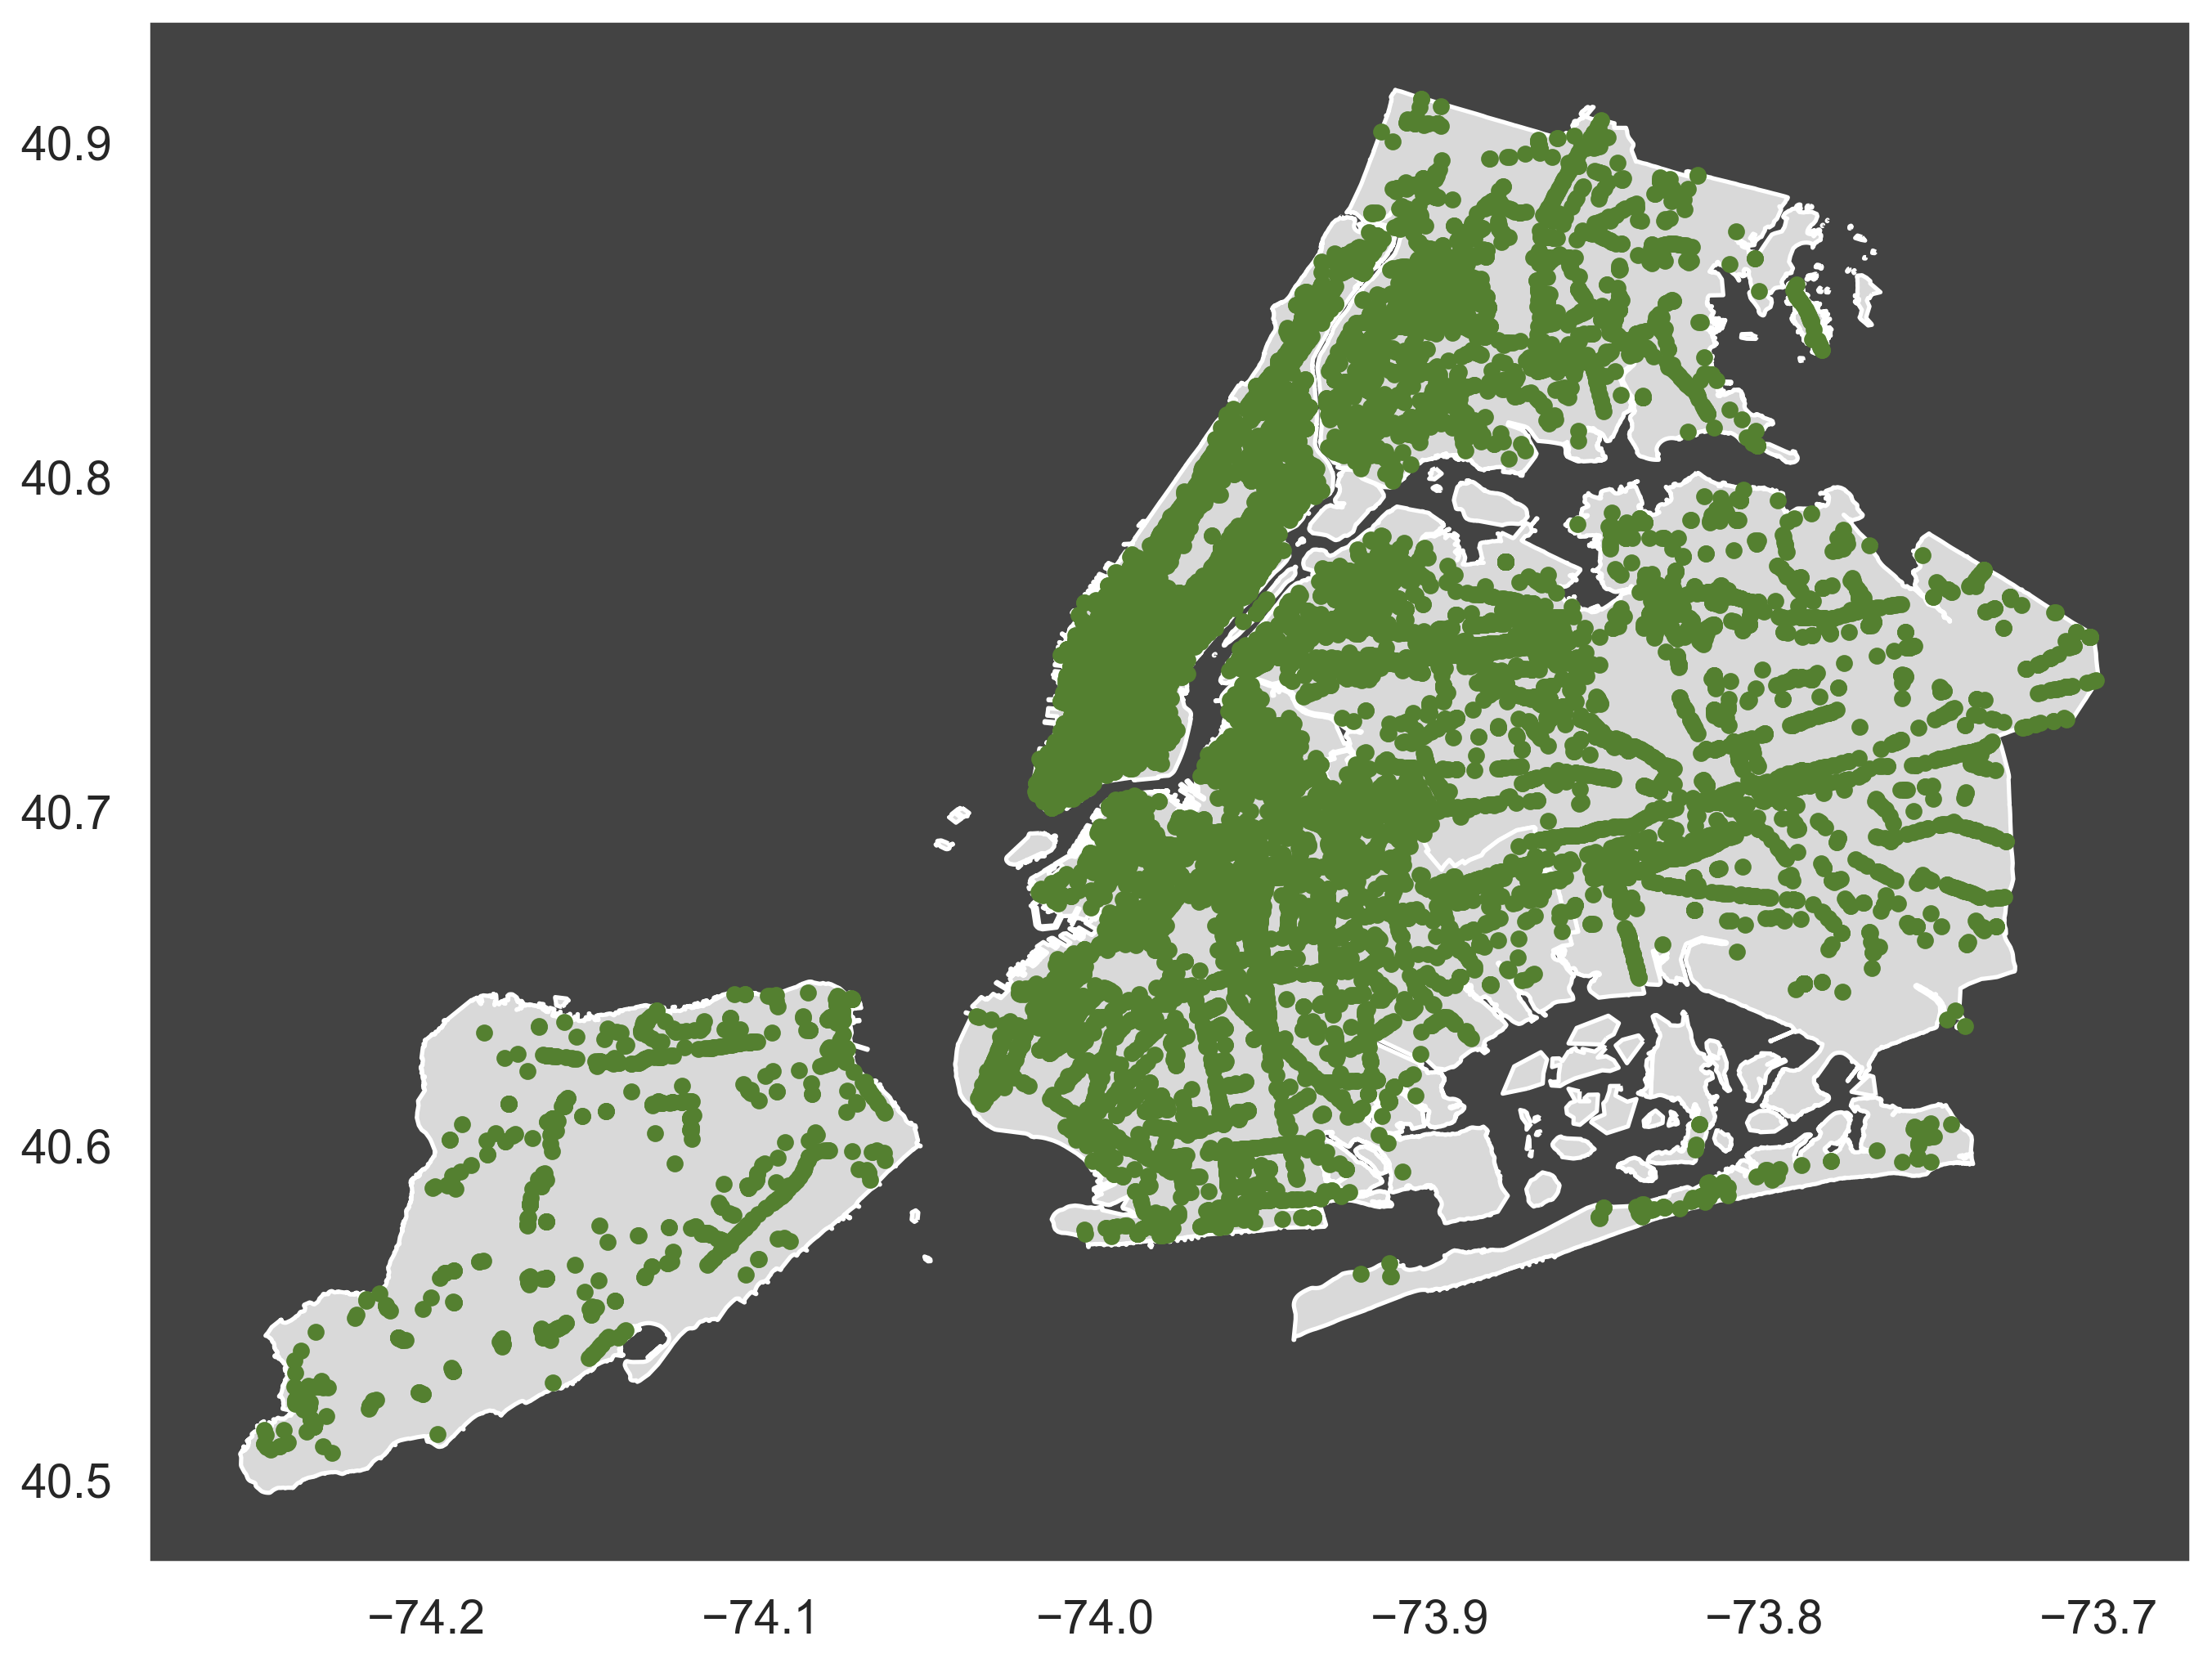

In [240]:
# Plot census tract map and real estate data
plt.rcParams['figure.figsize'] = (20, 10)
base_map = nyc.plot(color='0.85', edgecolor='white')
base_map.set_facecolor('#434343ff')
HD_gd.plot(ax=base_map, markersize=20, color='#548030', alpha=1) #with transparency
plt.savefig('/Users/rabarry/Documents/Insight/NYC data/SafeEats/visualizations/Map.png')

In [255]:
HD_gd['is_good_lastInsp']= np.where(HD_gd['is_good_lastInsp']==1, 'clean', 'dirty')
HD_gd['is_good_lastInsp'].value_counts()

clean    17105
dirty     6654
Name: is_good_lastInsp, dtype: int64

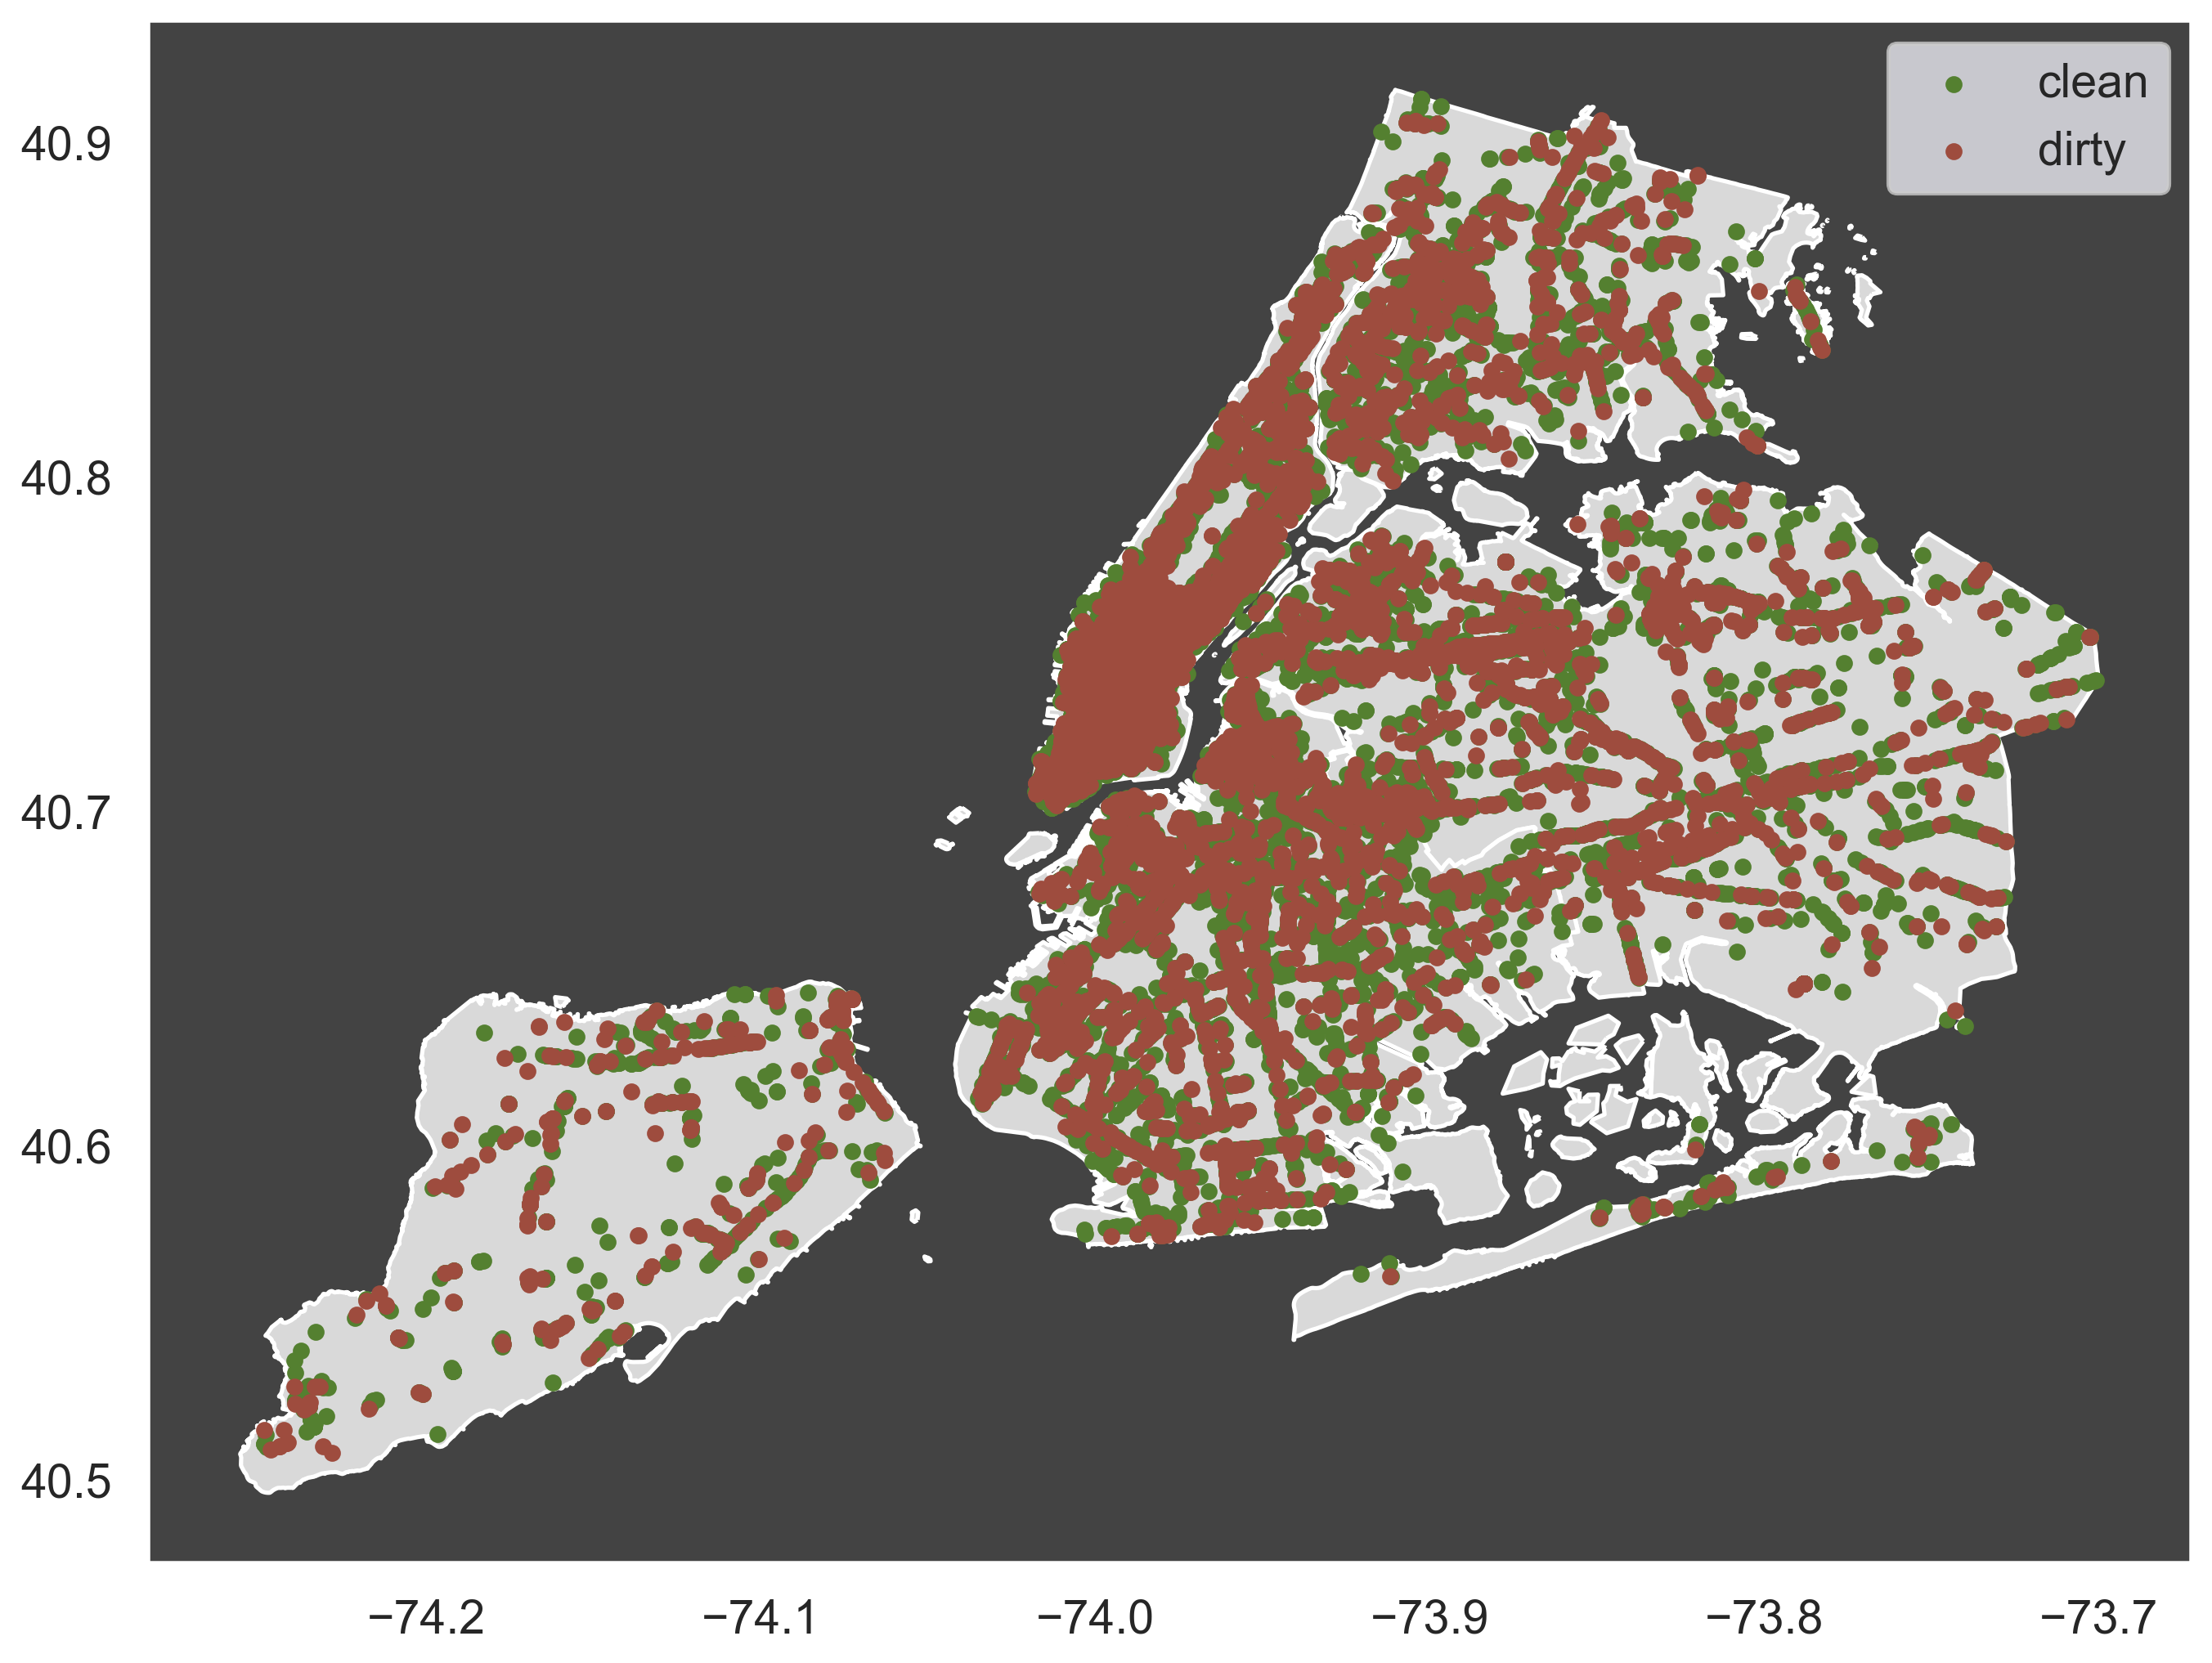

In [257]:
plt.rcParams['figure.figsize'] = (20, 10)
base_map = nyc.plot(color='0.85', edgecolor='white')
base_map.set_facecolor('#434343ff')
colors = {'clean': '#548030', 'dirty': '#9e4c3e'}
grouped = HD_gd.groupby('is_good_lastInsp')
for key, group in grouped:
    group.plot(ax=base_map, markersize=20, label = key, color = colors[key])
plt.legend()
plt.savefig('/Users/rabarry/Documents/Insight/NYC data/SafeEats/visualizations/Resuls_Map.png')

## Generate some exploratory plots

In [118]:
dataforplots = data.copy()
dataforplots.rename(columns = {'Cuisine_Reduced': "Cuisine Type"}, inplace=True)
dataforplots.rename(columns = {'is_good_lastInsp': 'Clean?'}, inplace=True)
dataforplots.rename(columns = {'BORO': "Borough"}, inplace=True)
dataforplots.rename(columns = {'Second_Last_Insp_Type': "Previous Inspection Type"}, inplace=True)
dataforplots.rename(columns = {'num_years_active': "Age of restaurant"}, inplace=True)

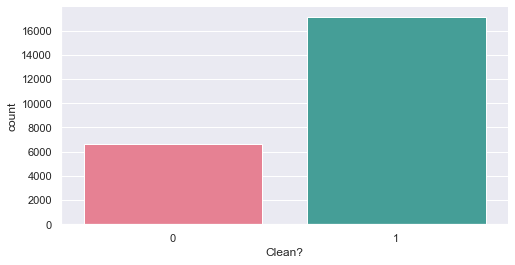

In [119]:
sns.set(rc={'figure.figsize':(8,4)})
sns.countplot(x = dataforplots['Clean?'], palette = 'husl')
sns.despine()

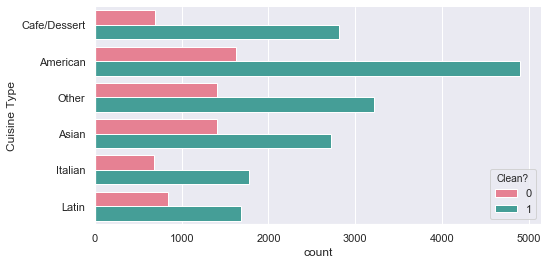

In [121]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.countplot(y=dataforplots["Cuisine Type"], hue = dataforplots['Clean?'], palette = 'husl')
sns.despine()
plt.savefig('/Users/rabarry/Documents/Insight/NYC data/SafeEats/Cuisine_Violations.png')

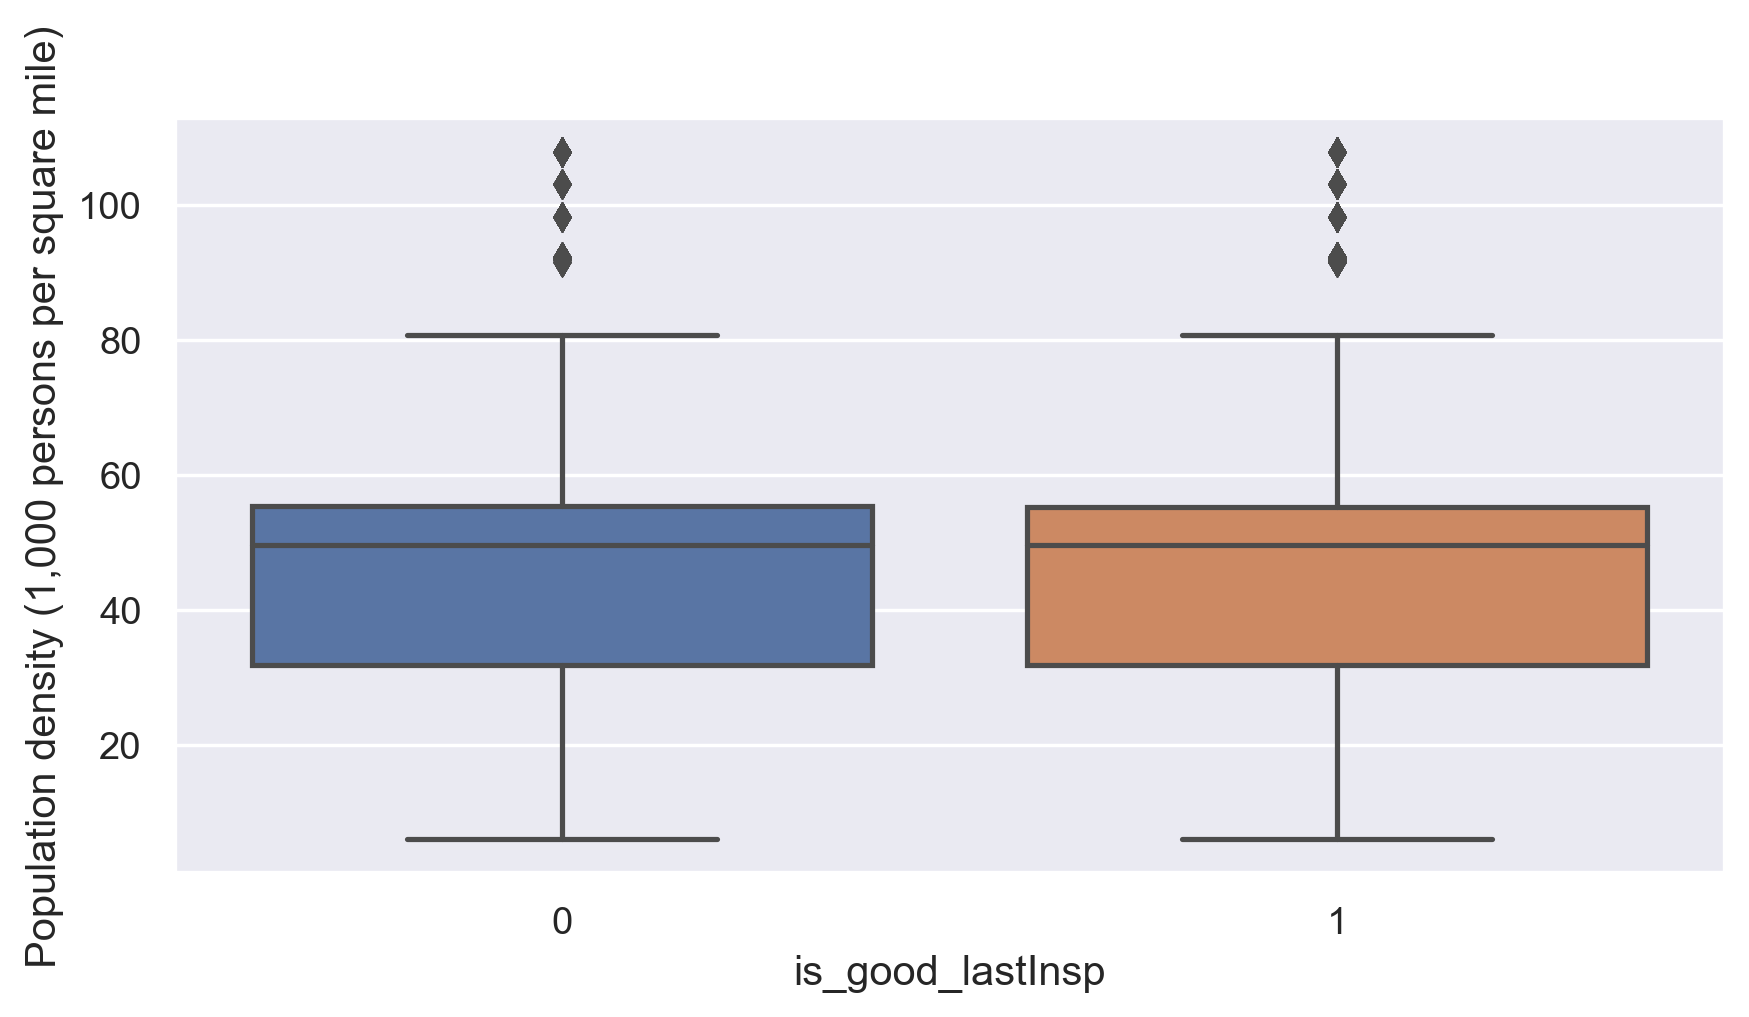

In [298]:
sns.set(rc={'figure.figsize':(8,4)})
sns.boxplot(y=data['Population'], x=data['is_good_lastInsp'])
sns.boxplot(y=data['Population density (1,000 persons per square mile)'], x=data['is_good_lastInsp'])
sns.boxplot(y=data['Serious housing code violations (per 1,000 privately owned rental units)'], x=data['is_good_lastInsp'])

## Specify the columns that will be included in the model
Also, remove any rows containing NaN

In [272]:
data4model = data[['avg_num_critical_flags_per_year','ny311_number_of_complaints_3mo',
       'Second_Last_Insp_Type_CAT', 'Second_Last_Insp_Num_CriticialFlags_CAT',
       'BORO_CAT', 'num_years_active_CAT', 'Cuisine_CAT', 
       'Population', 'Population density (1,000 persons per square mile)',
       'Serious housing code violations (per 1,000 privately owned rental units)', 'is_good_lastInsp']]
data4model = data4model.dropna()
data4model.shape

(23381, 11)

### Specify the labels (y data)

In [273]:
Good_y = data4model['is_good_lastInsp']
Good_y = np.ravel(Good_y)
Good_y.shape

(23381,)

### Specify the features (x data)

In [274]:
Good_x = data4model[['avg_num_critical_flags_per_year','ny311_number_of_complaints_3mo',
       'Second_Last_Insp_Type_CAT', 'Second_Last_Insp_Num_CriticialFlags_CAT',
       'BORO_CAT', 'num_years_active_CAT', 'Cuisine_CAT', 
       'Population', 'Population density (1,000 persons per square mile)',
       'Serious housing code violations (per 1,000 privately owned rental units)']]
Good_x.shape
Good_x.dtypes

(23381, 10)

avg_num_critical_flags_per_year                                              float64
ny311_number_of_complaints_3mo                                              category
Second_Last_Insp_Type_CAT                                                       int8
Second_Last_Insp_Num_CriticialFlags_CAT                                     category
BORO_CAT                                                                        int8
num_years_active_CAT                                                        category
Cuisine_CAT                                                                     int8
Population                                                                   float64
Population density (1,000 persons per square mile)                           float64
Serious housing code violations (per 1,000 privately owned rental units)     float64
dtype: object

### Plot correlation matrix

<Figure size 5000x2500 with 0 Axes>

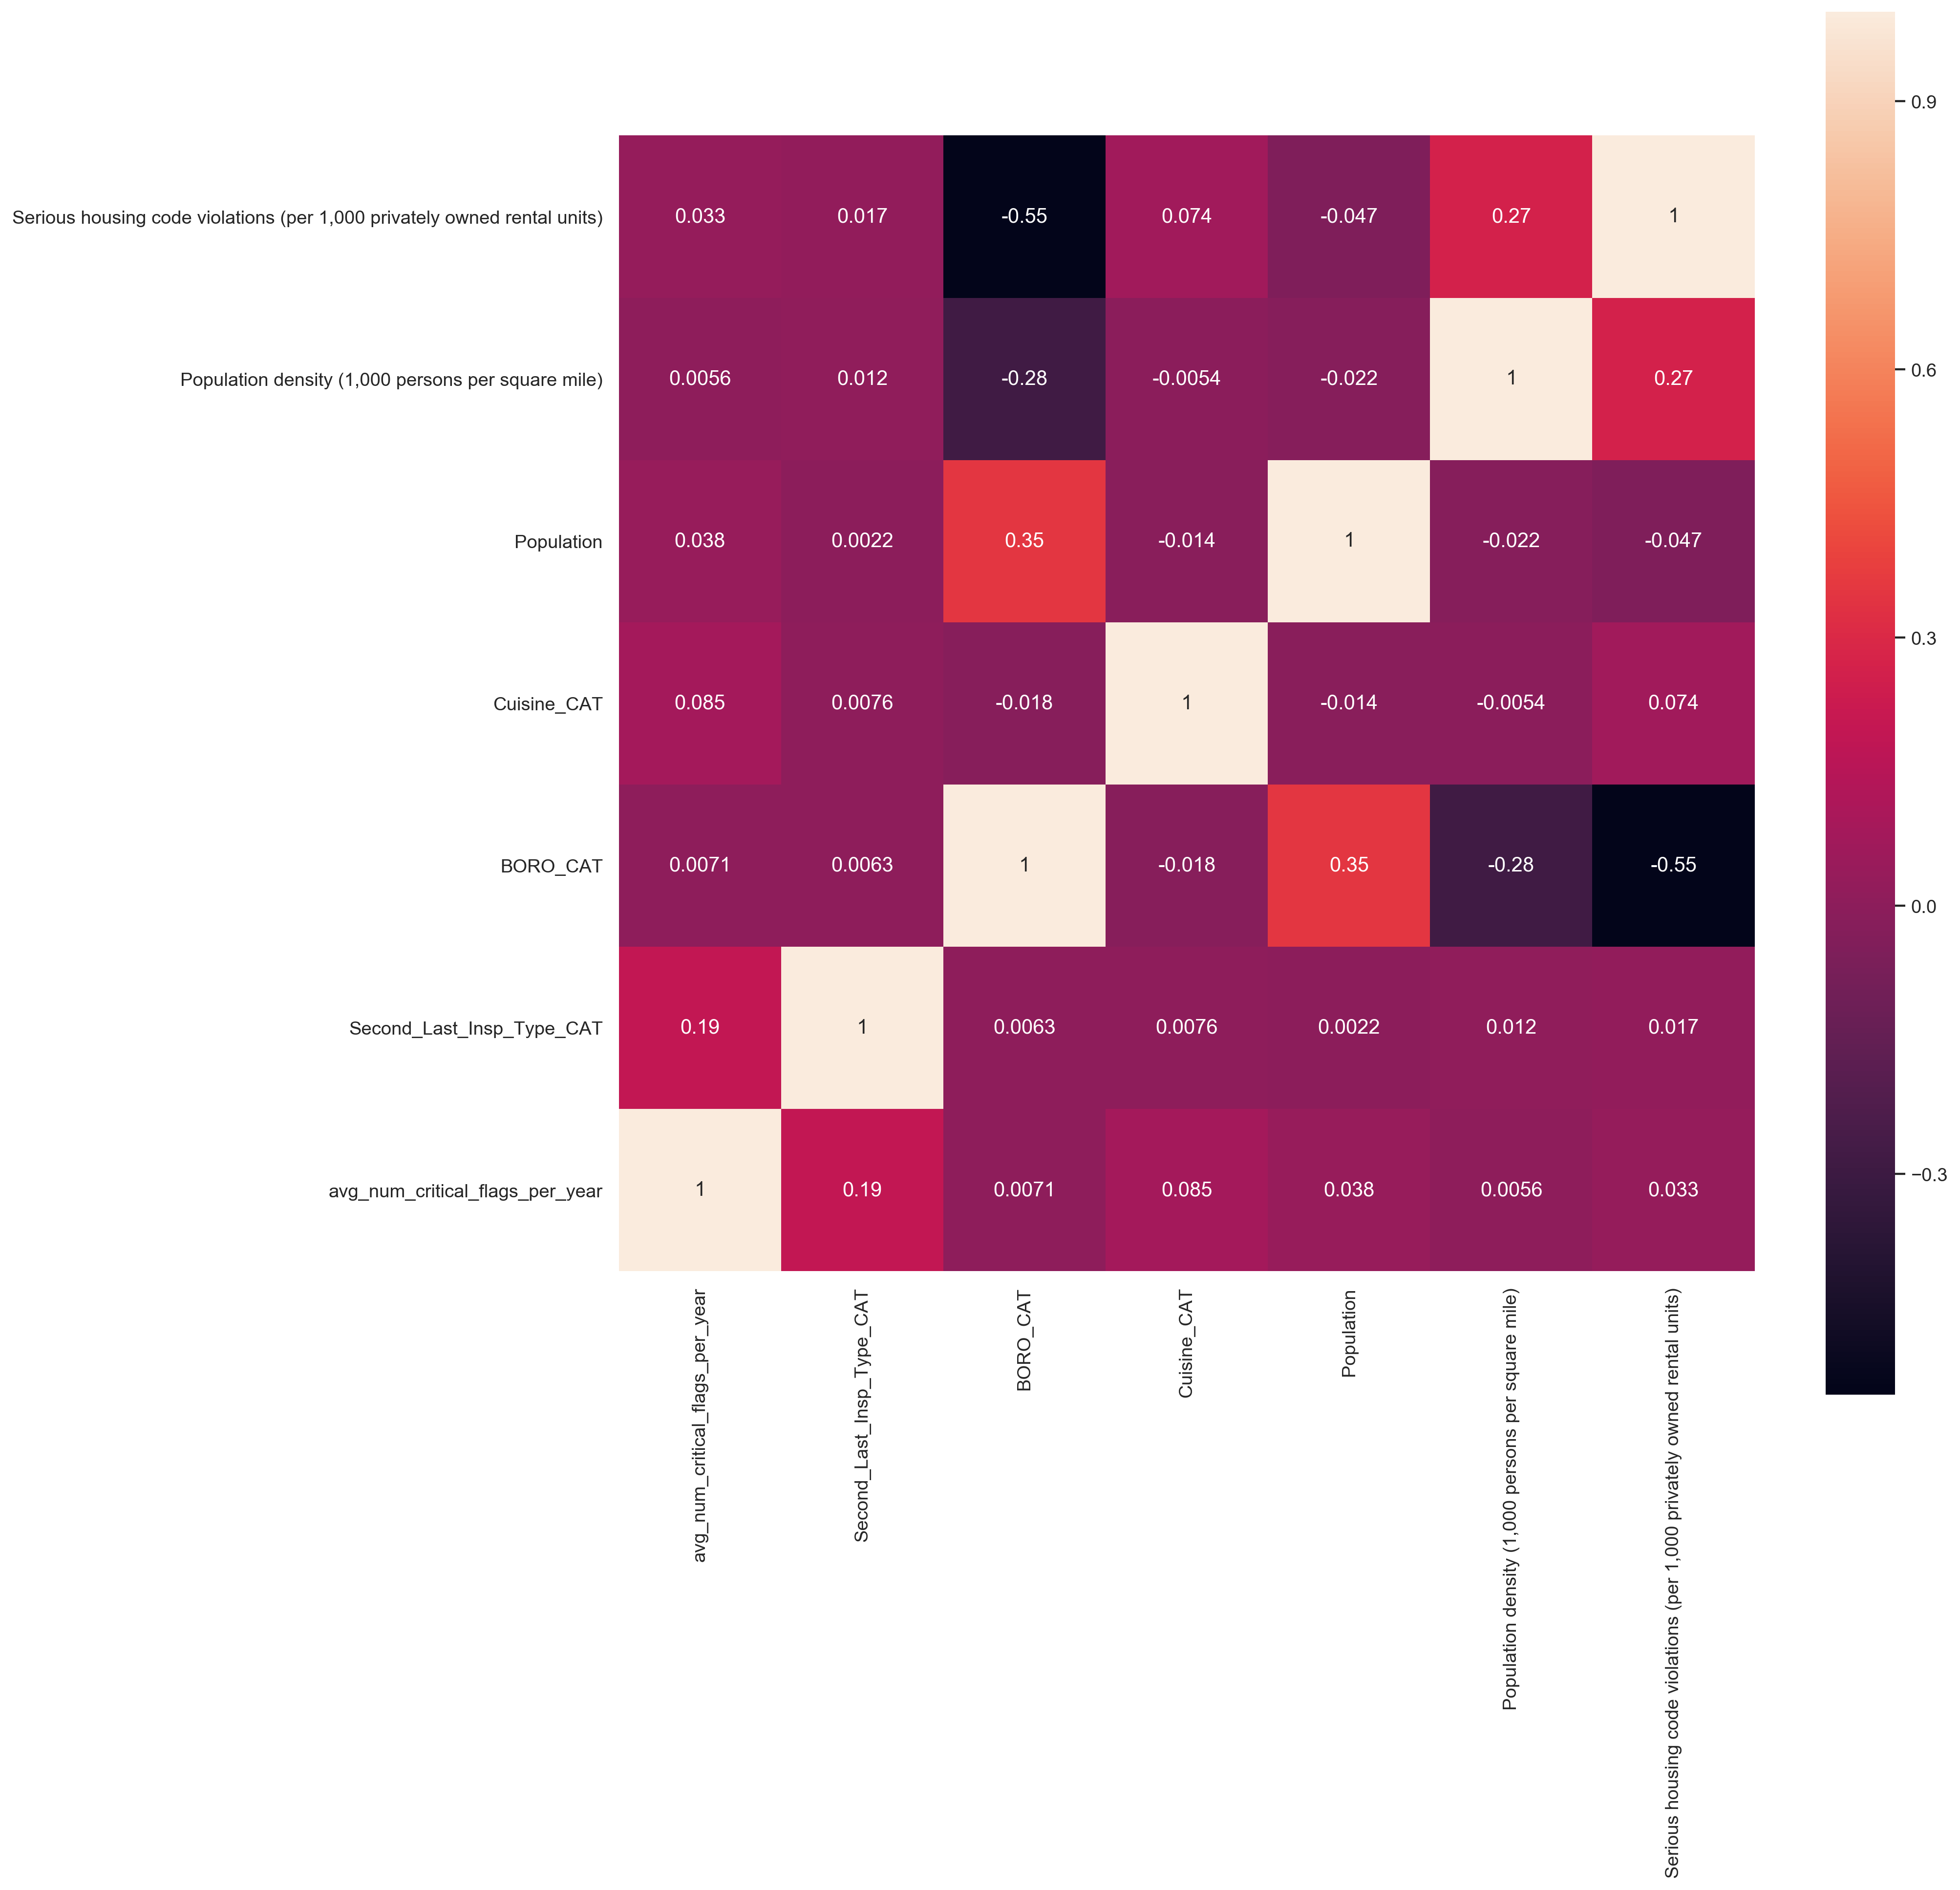

In [275]:
sns.set_context("notebook");
plt.tight_layout();
corr=Good_x.corr();
plt.figure(figsize=(15,15));
g = sns.heatmap(corr, cbar=True, annot=True, square=True)
g.set_ylim(0,7);
#plt.savefig('Correlation_Matrix.png')

### Train/Test split 80/20

In [276]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Good_x, Good_y, test_size=0.20, random_state=123, shuffle = True)

In [300]:
print(f"\033[1m\033[94mSize of training features: \033[30m{x_train.shape}")
print(f"\033[1m\033[94mSize of training labels: \033[30m{y_train.shape}")
print(f'\033[1m\033[94mSize of test features: \033[30m{x_test.shape}')
print(f'\033[1m\033[94mSize of test labels: \033[30m{y_test.shape}')

Size of training features: (18704, 10)
Size of training labels: (18704,)
Size of test features: (4677, 10)
Size of test labels: (4677,)


In [301]:
print('[Num Dirty, Num Clean]')
unique_elements, count_elements = np.unique(y_train, return_counts=True)
print(np.asarray(count_elements))
unique_elements, count_elements = np.unique(y_test, return_counts=True)
print(np.asarray(count_elements))


[Num Dirty, Num Clean]
[ 5242 13462]
[1320 3357]


### Normalize values to be between 0 and 1

In [302]:
# Normalize continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

# Model 1: Logistic Regression
### Grid search to maximize precision

In [303]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [304]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression();
logisticRegr.fit(x_train, y_train);

### Generate predictions

In [305]:
predictions_logistic_test_base = logisticRegr.predict(x_test)

predictions_logistic_train_base = logisticRegr.predict(x_train)

### Get recall and precision. Precision is most important for my question!!

In [306]:
recall_train = recall_score(y_train, predictions_logistic_train_base)
recall_test = recall_score(y_test, predictions_logistic_test_base)

print(f'\033[1m\033[94mRecall of the TRAINING data is : \033[30m{recall_train}')
print(f'\033[1m\033[94mRecall of the TEST data is : \033[30m{recall_test}\n')

precision_train = precision_score(y_train, predictions_logistic_train_base)
precision_test = precision_score(y_test, predictions_logistic_test_base)

print(f'\033[1m\033[94mPrecision of the TRAINING data is : \033[30m{precision_train}')
print(f'\033[1m\033[94mPrecision of the TEST data is : \033[30m{precision_test}\n')

f1_train = f1_score(y_train, predictions_logistic_train_base)
f1_test = f1_score(y_test, predictions_logistic_test_base)

print(f'\033[1m\033[94mF1 of the TRAINING data is : \033[30m{f1_train}')
print(f'\033[1m\033[94mF1 of the TEST data is : \033[30m{f1_test}\n')

#Make probability predictions
train_prob_base = logisticRegr.predict_proba(x_train)[:,1]
test_prob_base = logisticRegr.predict_proba(x_test)[:,1]

print(f'\033[1m\033[94mTrain ROC AUC Score: \033[30m{roc_auc_score(y_train, train_prob_base)}')
print(f'\033[1m\033[94mTest ROC AUC  Score: \033[30m{roc_auc_score(y_test, test_prob_base)}\n')

Recall of the TRAINING data is : 0.9487446144703611
Recall of the TEST data is : 0.9511468573130771

Precision of the TRAINING data is : 0.7437689261588633
Precision of the TEST data is : 0.7442890442890443

F1 of the TRAINING data is : 0.833844747665992
F1 of the TEST data is : 0.835098731528704

Train ROC AUC Score: 0.7150312272718591
Test ROC AUC  Score: 0.7198769418943682



### plot confusion matrices

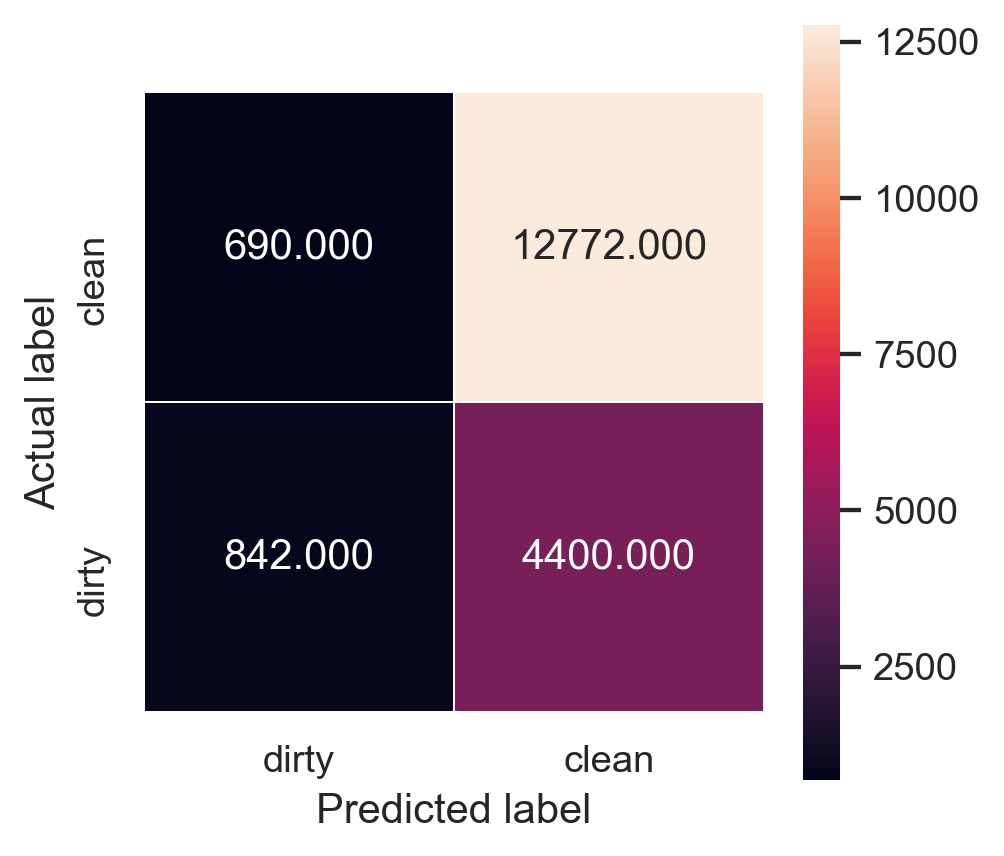

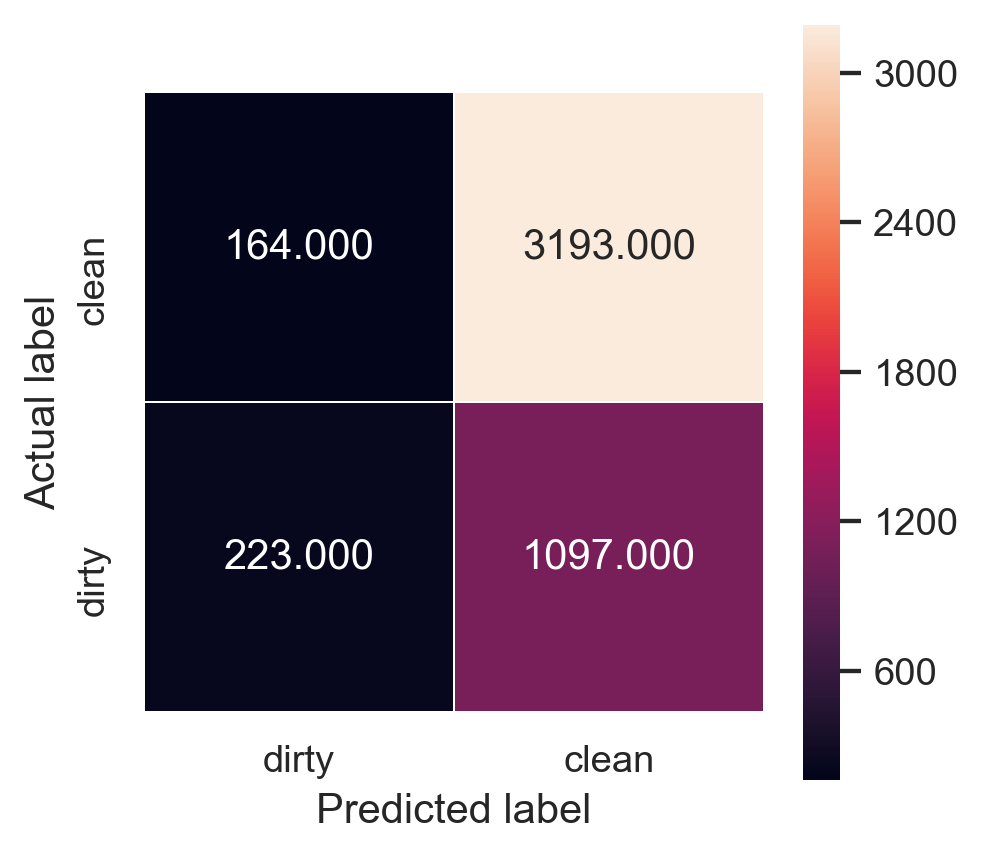

In [309]:
sns.set_context('notebook');
Outcome = ['dirty', 'clean'];
cm = metrics.confusion_matrix(y_train, predictions_logistic_train_base);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('');
g.set_ylim(0,2);
plt.savefig('Confusion_Matrix.png')

sns.set_context('notebook');
cm = metrics.confusion_matrix(y_test, predictions_logistic_test_base);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
g.set_ylim(0,2);
g.set_xlim(0,2);
plt.savefig('BaseModel_Confusion_Matrix.png')

### Try different confusion matrix version

In [285]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, predictions_logistic_test_base)
print(cnf_matrix)

FP = cnf_matrix[0,1]
TN = cnf_matrix[0,0]
TP = cnf_matrix[1,1]
FN = cnf_matrix[1,0]

FP = FP.astype(float)
TN = TN.astype(float)
TP = TP.astype(float)
FN = FN.astype(float)

# Fall out or false positive rate
log_FPR = FP/(FP+TN)
log_ACC = (TP + TN)/(TP + TN + FP + FN)
log_SPEC = TN/(TN + FP)
print(f"\033[1m\033[94mLogistic False Positive Rate: \033[30m{log_FPR}")
print(f"\033[1m\033[94mLogistic Accuracy Rate: \033[30m{log_ACC}")
print(f"\033[1m\033[94mLogistic Specificity: \033[30m{log_SPEC}")

[[ 223 1097]
 [ 164 3193]]
Logistic False Positive Rate: 0.831060606060606
Logistic Accuracy Rate: 0.7303827239683558
Logistic Specificity: 0.16893939393939394


# Model2: Logistic regression with SMOTE
### Grid Search used to maximize precision

#### Resample data to deal with class imbalance

In [286]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [287]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [288]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression();
grid_values = {'penalty': ['l1', 'l2'], 'C': [.001, .009, .01, .09, 1, 5, 10, 25]};
grid_logistic = GridSearchCV(logisticRegr, param_grid = grid_values, scoring = 'precision');
grid_logistic.fit(x_train_res, y_train_res);

#### save best estimator found in grid search

In [289]:
logistic_best = grid_logistic.best_estimator_

# View The Best Parameters
print(f"\033[1m\033[94mBest C: \033[30m{grid_logistic.best_estimator_.get_params()['C']}")
print(f"\033[1m\033[94mBest penalty: \033[30m{grid_logistic.best_estimator_.get_params()['penalty']}")
print(f"\033[1m\033[94mBest solver: \033[30m{grid_logistic.best_estimator_.get_params()['solver']}")


Best C: 10
Best penalty: l2
Best solver: lbfgs


#### Generate predictions

In [290]:
predictions_logistic_test = logistic_best.predict(x_test)

predictions_logistic_train = logistic_best.predict(x_train_res)

#### Get recall and precision. Precision is most important for my question!!

In [310]:
recall_train = recall_score(y_train_res, predictions_logistic_train)
recall_test = recall_score(y_test, predictions_logistic_test)

print(f'\033[1m\033[94mRecall of the TRAINING data is : \033[30m{recall_train}')
print(f'\033[1m\033[94mRecall of the TEST data is : \033[30m{recall_test}\n ')

precision_train = precision_score(y_train_res, predictions_logistic_train)
precision_test = precision_score(y_test, predictions_logistic_test)

print(f'\033[1m\033[94mPrecision of the TRAINING data is : \033[30m{precision_train}')
print(f'\033[1m\033[94mPrecision of the TEST data is : \033[30m{precision_test}\n ')

f1_train = f1_score(y_train_res, predictions_logistic_train)
f1_test = f1_score(y_test, predictions_logistic_test)

print(f'\033[1m\033[94mF1 of the TRAINING data is : \033[30m{f1_train}')
print(f'\033[1m\033[94mF1 of the TEST data is : \033[30m{f1_test}\n')

#Make probability predictions
train_prob = logistic_best.predict_proba(x_train_res)[:,1]
test_prob = logistic_best.predict_proba(x_test)[:,1]

print(f'\033[1m\033[94mTrain ROC AUC Score: \033[30m{roc_auc_score(y_train_res, train_prob)}')
print(f'\033[1m\033[94mTest ROC AUC  Score: \033[30m{roc_auc_score(y_test, test_prob)}\n')

Recall of the TRAINING data is : 0.7188382112613282
Recall of the TEST data is : 0.7039022937146262
 
Precision of the TRAINING data is : 0.6235984018559093
Precision of the TEST data is : 0.8148275862068965
 
F1 of the TRAINING data is : 0.66783988957902
F1 of the TEST data is : 0.7553140482659422

Train ROC AUC Score: 0.7227117181183456
Test ROC AUC  Score: 0.7209405268051381



<Figure size 288x288 with 0 Axes>

Text(12.453125, 0.5, 'Actual label')

Text(0.5, 76.533125, 'Predicted label')

Text(0.5, 1, 'Training Data')

(0, 2)

<Figure size 432x432 with 0 Axes>

Text(22.421875, 0.5, 'Actual label')

Text(0.5, 118.54187499999998, 'Predicted label')

Text(0.5, 1, 'Test Data')

(0, 2)

(0, 2)

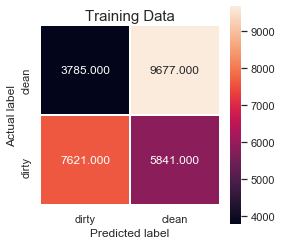

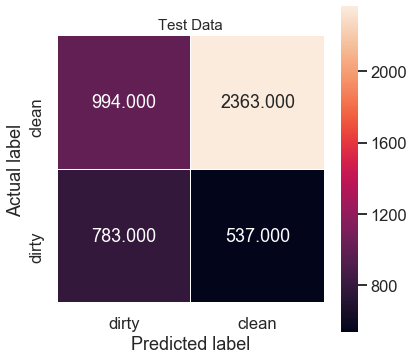

In [62]:
sns.set_context('notebook');
Outcome = ['dirty', 'clean'];
cm = metrics.confusion_matrix(y_train_res, predictions_logistic_train);
plt.figure(figsize=(4,4));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Training Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);
plt.savefig('Confusion_Matrix.png')

cm = metrics.confusion_matrix(y_test, predictions_logistic_test);
plt.figure(figsize=(6,6));
g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True,
           xticklabels=Outcome,
           yticklabels=Outcome);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Test Data';
plt.title(all_sample_title, size = 15);
g.set_ylim(0,2);
g.set_xlim(0,2);
plt.savefig('Final_Confusion_Matrix.png')

In [293]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, predictions_logistic_test)
print(cnf_matrix)

FP = cnf_matrix[0,1]
TN = cnf_matrix[0,0]
TP = cnf_matrix[1,1]
FN = cnf_matrix[1,0]

FP = FP.astype(float)
TN = TN.astype(float)
TP = TP.astype(float)
FN = FN.astype(float)

# Fall out or false positive rate
log_FPR = FP/(FP+TN)
log_ACC = (TP + TN)/(TP + TN + FP + FN)
log_SPEC = TN/(TN + FP)
print(f"\033[1m\033[94mLogistic False Positive Rate: \033[30m{log_FPR}")
print(f"\033[1m\033[94mLogistic Accuracy Rate: \033[30m{log_ACC}")
print(f"\033[1m\033[94mLogistic Specificity: \033[30m{log_SPEC}")

[[ 783  537]
 [ 994 2363]]
Logistic False Positive Rate: 0.4068181818181818
Logistic Accuracy Rate: 0.6726534103057515
Logistic Specificity: 0.5931818181818181


## Save model 

In [85]:
import pickle
import joblib
joblib.dump(logistic_best, 'final_model.pkl')
logistic_final_from_pickle = joblib.load('final_model.pkl')
model_predict = logistic_final_from_pickle.predict(x_test)

['final_model.pkl']

# Get feature importance

In [28]:
np.round(logistic_best.coef_,decimals=2)>0
Good_x.columns

array([[False,  True,  True,  True, False, False, False,  True, False,
         True]])

Index(['avg_num_critical_flags_per_year', 'ny311_number_of_complaints_3mo',
       'Second_Last_Insp_Type_CAT', 'Second_Last_Insp_Num_CriticialFlags_CAT',
       'BORO_CAT', 'num_years_active_CAT', 'Cuisine_CAT', 'Population',
       'Population density (1,000 persons per square mile)',
       'Serious housing code violations (per 1,000 privately owned rental units)'],
      dtype='object')

In [29]:
from sklearn.feature_selection import RFE
predictors = x_train_res
selector = RFE(logistic_best, n_features_to_select=1)
selector = selector.fit(predictors,y_train_res);

In [30]:
order = selector.ranking_
order
feature_ranks = []
for i in order:
    feature_ranks.append(f"{i}. {Good_x.columns[(i-1)]}")
feature_ranks

array([ 1,  2,  5,  8,  9,  3,  7, 10,  4,  6])

['1. avg_num_critical_flags_per_year',
 '2. ny311_number_of_complaints_3mo',
 '5. BORO_CAT',
 '8. Population',
 '9. Population density (1,000 persons per square mile)',
 '3. Second_Last_Insp_Type_CAT',
 '7. Cuisine_CAT',
 '10. Serious housing code violations (per 1,000 privately owned rental units)',
 '4. Second_Last_Insp_Num_CriticialFlags_CAT',
 '6. num_years_active_CAT']

In [56]:
from sklearn.feature_selection import SelectFromModel
smf = SelectFromModel(logistic_best, threshold=-np.inf, max_features= 3)
smf.fit(x_train_res, y_train_res)
feature_idx = smf.get_support()
feature_name = Good_x.columns[feature_idx]
feature_name

SelectFromModel(estimator=LogisticRegression(C=10, class_weight=None,
                                             dual=False, fit_intercept=True,
                                             intercept_scaling=1, l1_ratio=None,
                                             max_iter=100, multi_class='auto',
                                             n_jobs=None, penalty='l2',
                                             random_state=None, solver='lbfgs',
                                             tol=0.0001, verbose=0,
                                             warm_start=False),
                max_features=3, norm_order=1, prefit=False, threshold=-inf)

Index(['avg_num_critical_flags_per_year', 'ny311_number_of_complaints_3mo',
       'num_years_active_CAT'],
      dtype='object')

## Re-run logistic regression with only important features

### Chose SelectFromModel results

In [32]:
fewer_x = Good_x[['avg_num_critical_flags_per_year', 'ny311_number_of_complaints_3mo',
       'Second_Last_Insp_Type_CAT', 'num_years_active_CAT',
       'Population density (1,000 persons per square mile)']]

#### Train/Test split 80/20

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(fewer_x, Good_y, test_size=0.20, random_state=123, shuffle = True)

In [34]:
print(f'Size of training features: {x_train.shape}')
print(f'Size of training labels: {y_train.shape}')
print(f'Size of test features: {x_test.shape}')
print(f'Size of test labels: {y_test.shape}')

Size of training features: (18704, 5)
Size of training labels: (18704,)
Size of test features: (4677, 5)
Size of test labels: (4677,)


In [35]:
print('[Num Dirty, Num Clean]')
unique_elements, count_elements = np.unique(y_train, return_counts=True)
print(np.asarray(count_elements))
unique_elements, count_elements = np.unique(y_test, return_counts=True)
print(np.asarray(count_elements))


[Num Dirty, Num Clean]
[ 5242 13462]
[1320 3357]


#### Normalize values to be between 0 and 1

In [36]:
# Normalize continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

MinMaxScaler(copy=True, feature_range=(0, 1))

#### Resample data to deal with class imbalance

In [37]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [39]:
logisticRegr = LogisticRegression(C = 10, penalty = 'l2');
logisticRegr.fit(x_train_res, y_train_res);

#### Generate predictions

In [40]:
predictions_logistic_test = logisticRegr.predict(x_test)

predictions_logistic_train = logisticRegr.predict(x_train_res)

#### Get recall and precision. Precision is most important for my question!!

In [41]:
recall_train = recall_score(y_train_res, predictions_logistic_train)
recall_test = recall_score(y_test, predictions_logistic_test)

print(f'Recall of the TRAINING data is : {recall_train} ')
print(f'Recall of the TEST data is : {recall_test} ')
print('')

precision_train = precision_score(y_train_res, predictions_logistic_train)
precision_test = precision_score(y_test, predictions_logistic_test)

print(f'Precision of the TRAINING data is : {precision_train} ')
print(f'Precision of the TEST data is : {precision_test} ')
print('')

#Make probability predictions
train_prob = logisticRegr.predict_proba(x_train_res)[:,1]
test_prob = logisticRegr.predict_proba(x_test)[:,1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train_res, train_prob)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, test_prob)}')

Recall of the TRAINING data is : 0.7272322091813995 
Recall of the TEST data is : 0.7149240393208222 

Precision of the TRAINING data is : 0.6202090592334495 
Precision of the TEST data is : 0.8138351983723296 

Train ROC AUC Score: 0.7209721886513905
Test ROC AUC  Score: 0.7216944918352424


# SMOTE undersample/oversample

#### Normalize values to be between 0 and 1

In [85]:
# Normalize continuous variables
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(Good_x)
x_scaled = scaler.transform(Good_x)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [90]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

#define pipeline
model = LogisticRegression()
over = SMOTE(sampling_strategy = 0.5)
under = RandomUnderSampler()
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

#evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=123)
scores = cross_val_score(pipeline, x_scaled, Good_y, scoring = 'precision', cv=cv, n_jobs=-1)
print('Mean Precision: %.3f' %np.mean(scores))

Mean Precision: 0.808
